In [5]:
import gzip
from collections import defaultdict
from itertools import groupby

# schema: prec, rec, algInfo, cmpFnInfo, threshold, vpInfo, dName, info)

def openFiles(paths):
    for path in paths:
        with gzip.open(path, 'rt') as f:
            for line in f:
                yield line

def toTuples(lines):
    for line in lines:
        prec, rec, compRatio, algInfo, cmpFnInfo, threshold, vpInfo, dName, info = line.split(',')
        yield (
            float(prec),
            float(rec),
            float(compRatio),
            algInfo, 
            cmpFnInfo,
            float(threshold),
            tuple(vpInfo.split(' ')),
            dName,
            int(info)
        )

def toDicts(lines):
    for line in lines:
        prec, rec, compRatio, algInfo, cmpFnInfo, threshold, vpInfo, dName, info = line.split(',')
        yield {
            'precision': float(prec),
            'recall': float(rec),
            'compRation': float(compRatio),
            'algorithm': algInfo, 
            'compareFn': cmpFnInfo,
            'threshold': float(threshold),
            'viewpoints': tuple(vpInfo.split(' ')),
            'dataset': dName,
            'index': int(info)
        }

def filterBy(pred):
    def f(lines):
        for line in lines:
            if pred(line):
                yield line
    return f

def count(lines):
    i = 0
    for l in lines:
        i += 1
    yield i

def apply(fn):
    def f(lines):
        for line in lines:
            yield fn(line)
    return f

def unpack(lines):
    yield from zip(*lines)

def reduceBy(fn, init):
    def f(items):
        result = init
        for item in items:
            result = fn(result, item)
        return result
    return f

def groupBy(fn):
    def f(items):
        return groupby(items, key=fn)
    return f

def createPipeline(startGen, filters):
    generator = startGen
    for filter in filters:
        generator = filter(generator)
    return generator

In [6]:
from itertools import chain, combinations
def powerset(seq):
    '''Returns a powerset of seq without the empty set'''
    s = list(seq)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s) + 1))

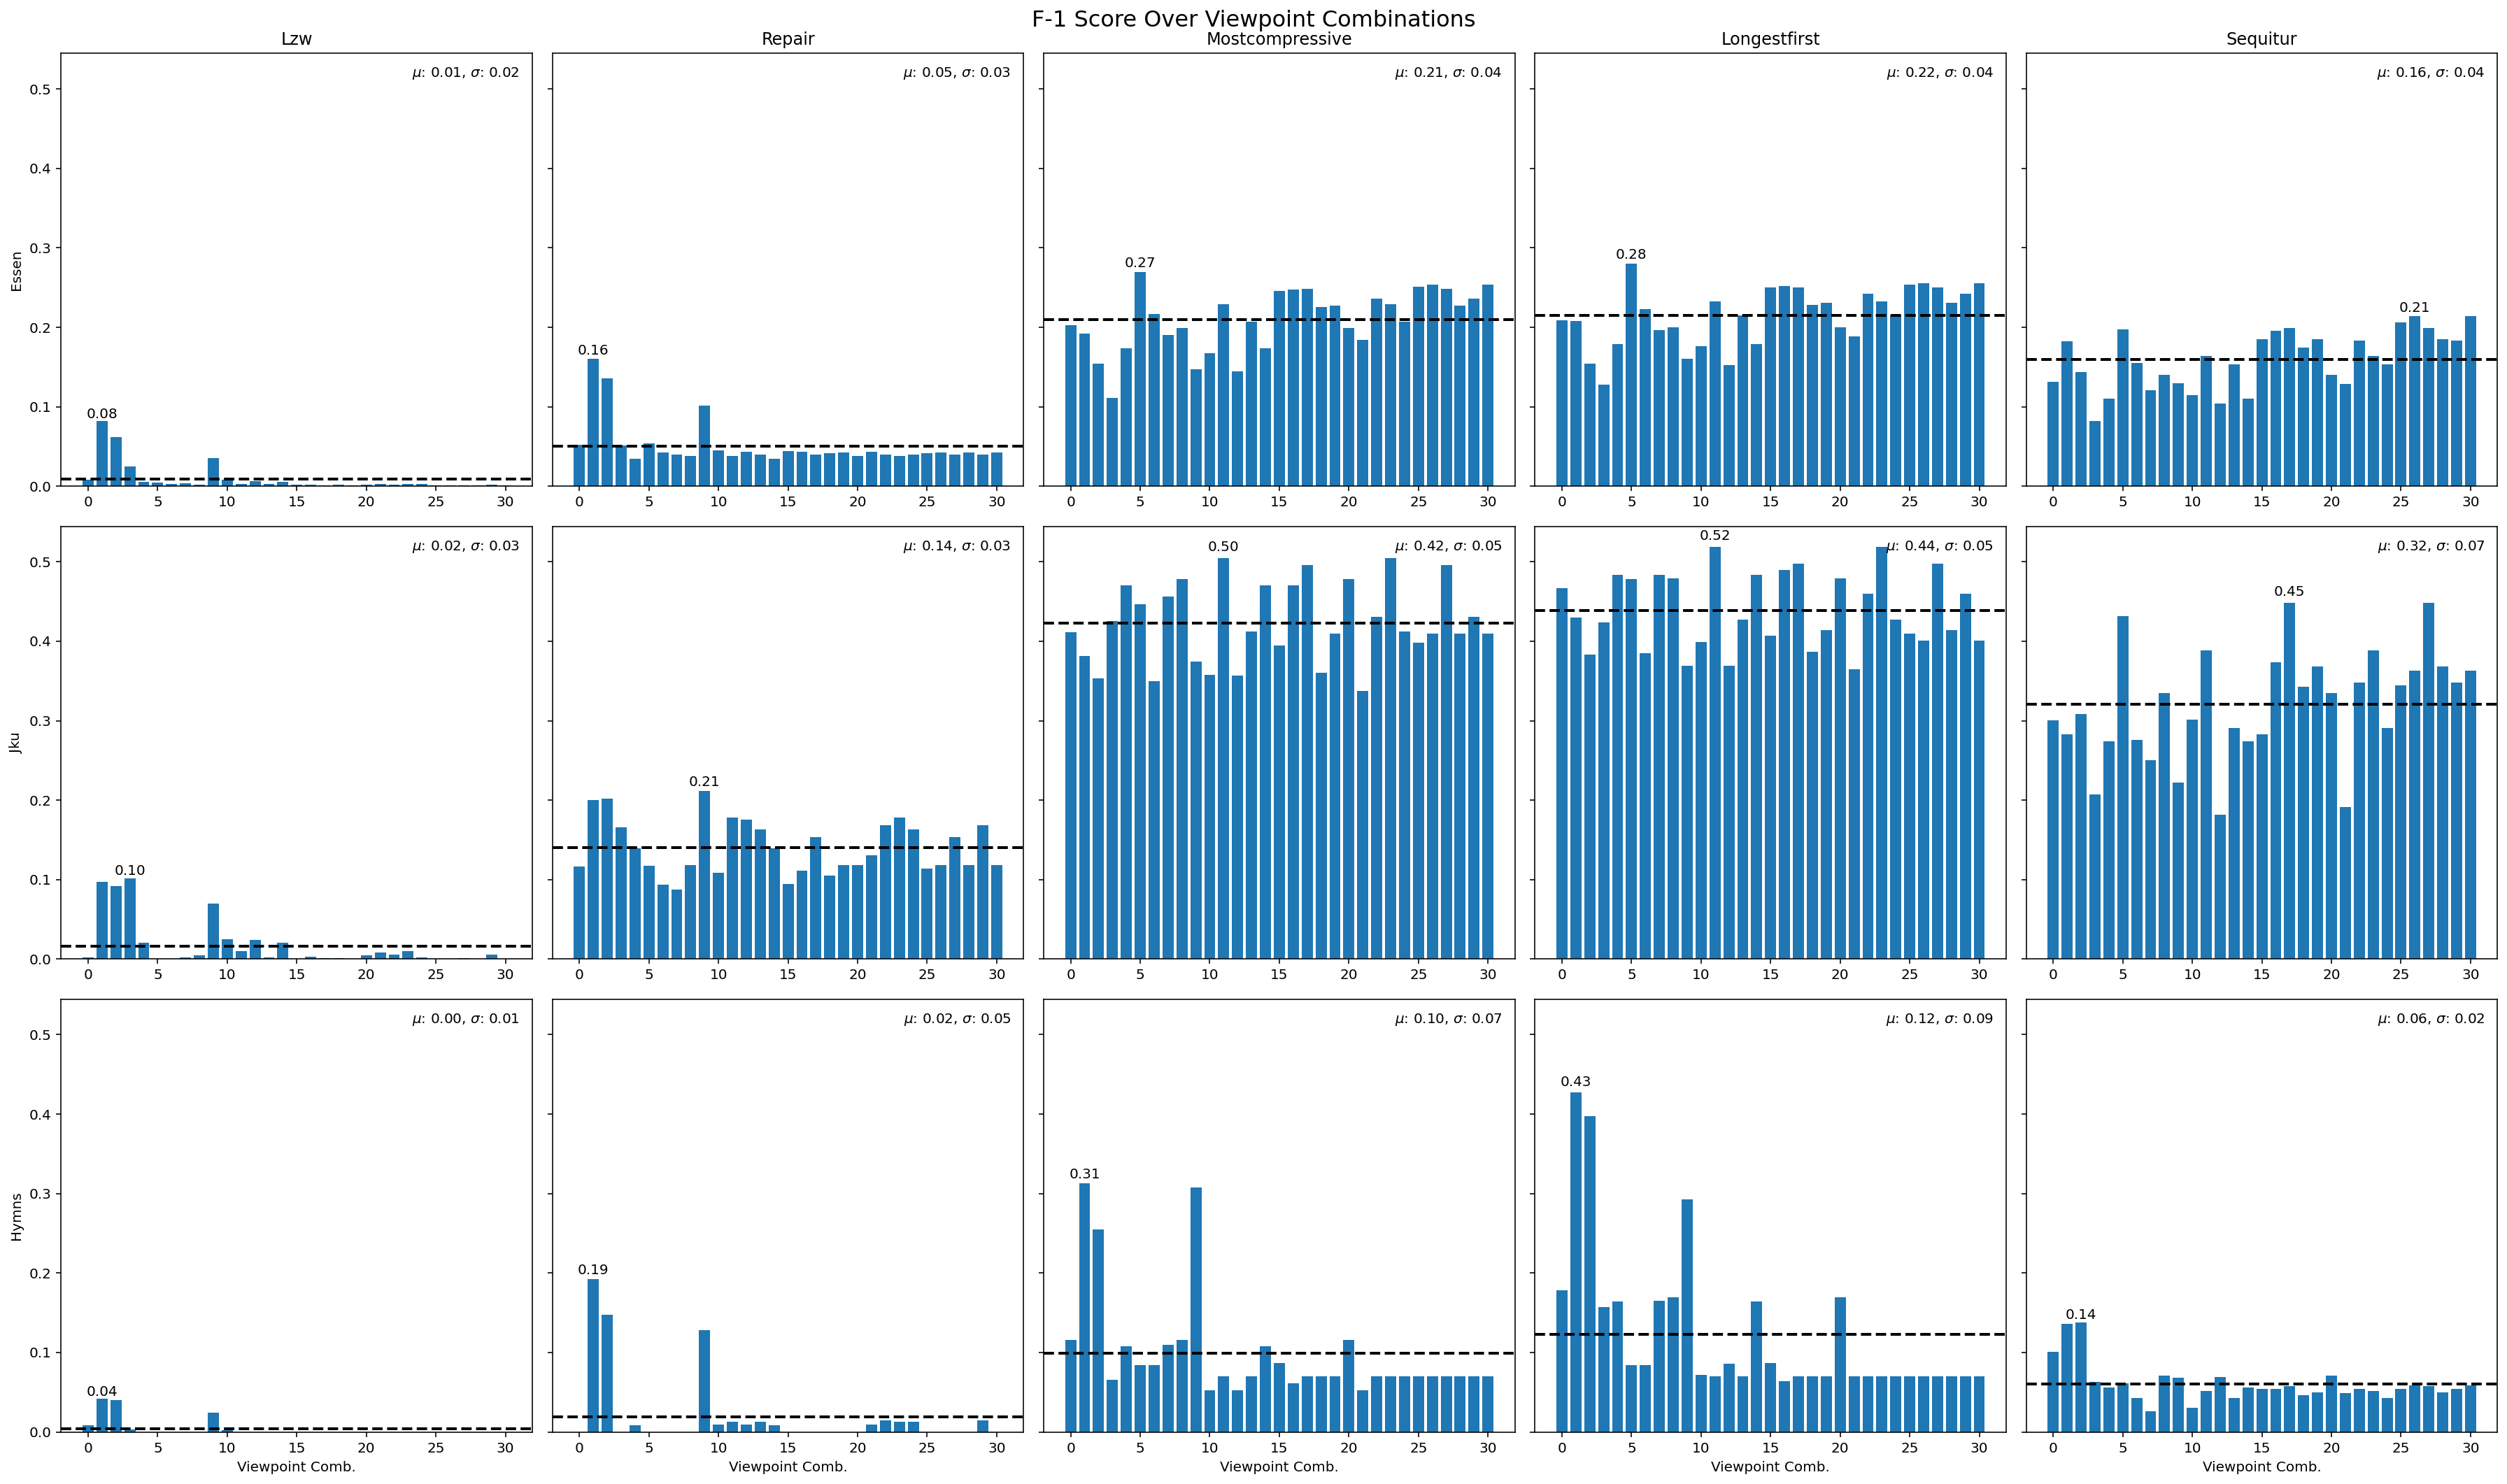

In [18]:
# Compute F-1 Score for each viewpoint combination

viewpoints = tuple(tuple(sorted(vp)) for vp in powerset(['midi', 'duration', 'interOnsetInterval', 'pitchContour', 'pitchInterval']))
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
scale = 5
fig, ax = plt.subplots(3, 5, sharey=True, figsize=(5*scale, 3*scale))
for i, dataset in enumerate(('essen', 'jku', 'hymns')):
    for j, algorithm in enumerate(('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur')):
        precisions = {v: [] for v in viewpoints}
        recalls = {v: [] for v in viewpoints}
        fs = {v: [] for v in viewpoints}
        pipeline = createPipeline(['../resultst80.gz'], [
            openFiles,
            toDicts,
            filterBy(lambda d: d['dataset'] == dataset and d['algorithm'] == algorithm)
        ])
        for d in pipeline:
            vp, p, r = d['viewpoints'], d['precision'], d['recall']
            precisions[vp].append(p)
            recalls[vp].append(r)
            fs[vp].append((2 * p * r) / (p + r) if p + r != 0 else 0)
        
        width = 0.35
        labels = range(1, len(viewpoints) + 1)
        x = np.arange(len(labels))
        prec = [np.mean(ps) for ps in precisions.values()]
        rec = [np.mean(rs) for rs in recalls.values()]
        rects = ax[i,j].bar(x, [np.mean(f) for f in fs.values()])

        # Annotate largest values
        maxHeight = 0
        index = 0
        heights = []
        for ii, r in enumerate(rects):
            height = r.get_height()
            heights.append(height)
            if height > maxHeight:
                maxHeight = height
                index = ii
        ax[i,j].text(rects[index].get_x() + rects[index].get_width()/2., 1.01*maxHeight, f'{maxHeight:.2f}', ha='center', va='bottom')

        # Annotation average line
        ax[i, j].axhline(np.mean(heights), color='black', linewidth=2, linestyle='--')

        # Annotate mean and std. deviation
        mu = np.mean(heights)
        sigma = np.std(heights)
        anchoredText = AnchoredText(rf'$\mu$: {mu:.2f}, $\sigma$: {sigma:.2f}', loc='upper right', frameon=False)
        ax[i, j].add_artist(anchoredText)
        # ax[i, j].annotate('Test', xy=(1, 0), xycoords='axes fraction', fontsize=16,
        #         xytext=(-5, 5), textcoords='offset points',
        #         ha='right', va='bottom')

    ax[i,0].set_ylabel(dataset.capitalize())
for j, algorithm in enumerate(('lzw', 'repair', 'mostCompressive', 'longestFirst', 'sequitur')):
    ax[0,j].set_title(algorithm.capitalize())
    ax[-1,j].set_xlabel('Viewpoint Comb.')
fig.suptitle('F-1 Score Over Viewpoint Combinations', fontsize=16)
fig.tight_layout()
# plt.show()
plt.savefig("../figures/resultst70.png", bbox_inches='tight')


In [4]:
for i, vp in enumerate(viewpoints):
    print(i, vp)

0 ('midi',)
1 ('duration',)
2 ('interOnsetInterval',)
3 ('pitchContour',)
4 ('pitchInterval',)
5 ('duration', 'midi')
6 ('interOnsetInterval', 'midi')
7 ('midi', 'pitchContour')
8 ('midi', 'pitchInterval')
9 ('duration', 'interOnsetInterval')
10 ('duration', 'pitchContour')
11 ('duration', 'pitchInterval')
12 ('interOnsetInterval', 'pitchContour')
13 ('interOnsetInterval', 'pitchInterval')
14 ('pitchContour', 'pitchInterval')
15 ('duration', 'interOnsetInterval', 'midi')
16 ('duration', 'midi', 'pitchContour')
17 ('duration', 'midi', 'pitchInterval')
18 ('interOnsetInterval', 'midi', 'pitchContour')
19 ('interOnsetInterval', 'midi', 'pitchInterval')
20 ('midi', 'pitchContour', 'pitchInterval')
21 ('duration', 'interOnsetInterval', 'pitchContour')
22 ('duration', 'interOnsetInterval', 'pitchInterval')
23 ('duration', 'pitchContour', 'pitchInterval')
24 ('interOnsetInterval', 'pitchContour', 'pitchInterval')
25 ('duration', 'interOnsetInterval', 'midi', 'pitchContour')
26 ('duration', 'i

In [19]:
from pathlib import Path
resultFile = Path('../resultst80.gz')
bests = {}
for algorithm in ('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur'):
    print(algorithm)
    for index in range(20):
        pipeline = createPipeline([resultFile], [
            openFiles, 
            toDicts,
            filterBy(lambda d: d['dataset'] == 'hymns' and d['index'] == index and d['algorithm'] == algorithm)
        ])
        bestF1 = float('-inf')
        bestVpComb = []
        for d in pipeline:
            prec = d['precision']
            rec = d['recall']
            if prec == 0 or rec == 0:
                continue
            f1 = (2 * prec * rec) / (prec + rec)
            if f1 > bestF1:
                bestF1 = f1
                bestVpComb = [d['viewpoints']]
            elif f1 == bestF1:
                bestVpComb.append(d['viewpoints'])
        # break
        print('\t', index, bestF1, bestVpComb)


lz78
	 0 -inf []
	 1 -inf []
	 2 -inf []
	 3 -inf []
	 4 -inf []
	 5 -inf []
	 6 0.2222222222222222 [('duration',), ('interOnsetInterval',)]
	 7 -inf []
	 8 -inf []
	 9 -inf []
	 10 -inf []
	 11 0.16216216216216214 [('midi',)]
	 12 -inf []
	 13 -inf []
	 14 -inf []
	 15 0.19999999999999998 [('duration',)]
	 16 -inf []
	 17 0.36923076923076925 [('duration',)]
	 18 -inf []
	 19 -inf []
repair
	 0 -inf []
	 1 -inf []
	 2 0.28571428571428575 [('duration', 'interOnsetInterval', 'pitchInterval'), ('duration', 'interOnsetInterval', 'pitchContour', 'pitchInterval')]
	 3 -inf []
	 4 -inf []
	 5 -inf []
	 6 0.6666666666666666 [('interOnsetInterval',), ('duration',), ('duration', 'interOnsetInterval')]
	 7 -inf []
	 8 -inf []
	 9 -inf []
	 10 -inf []
	 11 -inf []
	 12 -inf []
	 13 0.47058823529411764 [('duration',), ('interOnsetInterval',)]
	 14 0.3076923076923077 [('duration',), ('interOnsetInterval',), ('duration', 'interOnsetInterval')]
	 15 1.0 [('duration',)]
	 16 -inf []
	 17 0.813559322033

In [21]:
from pathlib import Path
resultFile = Path('../resultst80.gz')
bests = {}
for algorithm in ('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur'):
    print(algorithm)

    pipeline = createPipeline([resultFile], [
        openFiles, 
        toDicts,
        filterBy(lambda d: d['dataset'] == 'hymns' and d['index'] == 6 and d['algorithm'] == algorithm)
    ])
    bestF1 = float('-inf')
    bestVpComb = []
    for d in pipeline:
        prec = d['precision']
        rec = d['recall']
        if prec == 0 or rec == 0:
            continue
        f1 = (2 * prec * rec) / (prec + rec)
        if f1 > bestF1:
            bestF1 = f1
            bestVpComb = [d['viewpoints']]
        elif f1 == bestF1:
            bestVpComb.append(d['viewpoints'])
    # break
    print('\t', index, bestF1, bestVpComb)
    bests[algorithm] = bestVpComb[0]
bests

lz78
	 19 0.2222222222222222 [('duration',), ('interOnsetInterval',)]
repair
	 19 0.6666666666666666 [('interOnsetInterval',), ('duration',), ('duration', 'interOnsetInterval')]
mostCompressive
	 19 0.6666666666666666 [('duration',), ('interOnsetInterval',), ('duration', 'interOnsetInterval')]
longestFirst
	 19 1.0 [('interOnsetInterval',)]
sequitur
	 19 0.6666666666666666 [('interOnsetInterval',), ('interOnsetInterval', 'pitchContour')]


{'lz78': ('duration',),
 'repair': ('interOnsetInterval',),
 'mostCompressive': ('duration',),
 'longestFirst': ('interOnsetInterval',),
 'sequitur': ('interOnsetInterval',)}

In [22]:
from viewpoint import duration, interOnsetInterval, createViewpointFn
from sequitur import sequitur
from lzw import lz78
from irr import repair, mostCompressive, longestFirst
from grammar import stringifyGrammar, convertGrammarToAnnotation, convertGrammarToAnnotation2
import sys
sys.path.append('../src')
from pathlib import Path
hymnsPath = Path('../datasets/hymns/sequences.txt')
# from hymns import load2 as loadHymnSequences
from hymns import loadSequences
from common import formatAnnotation

data = loadSequences(hymnsPath)
seq = data[6]
print(seq)

for algorithm, vpFn in zip([lz78, repair, mostCompressive, longestFirst, sequitur], [duration, duration, duration, duration, duration]):
    vp = createViewpointFn([vpFn])
    vpSeq = tuple(vp(seq))
    grammar = algorithm(vpSeq)
    print(algorithm.__name__)
    print(stringifyGrammar(grammar))
    ann = convertGrammarToAnnotation2(grammar)
    # ann = [a for a in ann if len(a) > 1]
    print(formatAnnotation(enumerate(ann)))
    # break

Loading sequences


100%|██████████| 20/20 [00:01<00:00, 18.89it/s]

[(0.0, 66, 1.0), (1.0, 71, 1.0), (2.0, 69, 1.0), (3.0, 67, 1.0), (4.0, 69, 1.0), (5.0, 66, 3.0), (8.0, 69, 1.0), (9.0, 74, 1.0), (10.0, 73, 1.0), (11.0, 71, 1.0), (12.0, 71, 1.0), (13.0, 69, 3.0), (16.0, 69, 1.0), (17.0, 71, 1.0), (18.0, 73, 1.0), (19.0, 74, 1.0), (20.0, 69, 1.0), (21.0, 67, 1.0), (22.0, 69, 1.0), (23.0, 66, 1.0), (24.0, 71, 1.0), (25.0, 69, 1.0), (26.0, 62, 1.0), (27.0, 66, 1.0), (28.0, 64, 1.0), (29.0, 62, 3.0)]
lz78
@0 -> @1,@2,@3,@4,@5,@6,@7,@8
@1 -> (1.0,)
@2 -> @1,(1.0,)
@3 -> @2,(3.0,)
@4 -> @2,(1.0,)
@5 -> @3,(1.0,)
@6 -> @4,(1.0,)
@7 -> @6,(1.0,)
@8 -> @4,(3.0,)
Pattern 1:
	Span 0:1
Pattern 2:
	Span 1:3
Pattern 3:
	Span 3:6
Pattern 4:
	Span 6:9
Pattern 5:
	Span 9:13
Pattern 6:
	Span 13:17
Pattern 7:
	Span 17:22
Pattern 8:
	Span 22:26

repair
@0 -> @4,@4,@2,@2,@4
@1 -> (1.0,),(1.0,)
@2 -> @1,@1
@3 -> @2,(1.0,)
@4 -> @3,(3.0,)
Pattern 1:
	Span 0:6
	Span 6:12
	Span 20:26
Pattern 2:
	Span 12:16
	Span 16:20

mostCompressive
@0 -> @2,@2,@1,@1,@2
@1 -> (1.0,),(1.0,),

In [25]:
# Compute average length of each sequence for each dataset
from common import gzPickleIter

datasets = [
    gzPickleIter('../datasets/essen/essen300.pkl.gz'),
    gzPickleIter('../datasets/jku/jku.pkl.gz'),
    gzPickleIter('../datasets/hymns/hymns.pkl.gz')
]

lengths = []
for d in datasets:
    lengths.append([len(x[0]) for x in d])
#     lengths.append([len(x) for x in d.items()])

print('Dataset, Mean Sequence Length, Standard Deviation')
for l, dataset in zip(lengths, ('Essen', 'Jku', 'Hymns')):
    print(f'{dataset}, {np.mean(l):.2f}, {np.std(l):.2f}')

Dataset, Mean Sequence Length, Standard Deviation
Essen, 64.22, 29.60
Jku, 677.20, 189.08
Hymns, 45.11, 16.29


Text(0.5, 0.98, 'Number of Patterns vs Span Length')

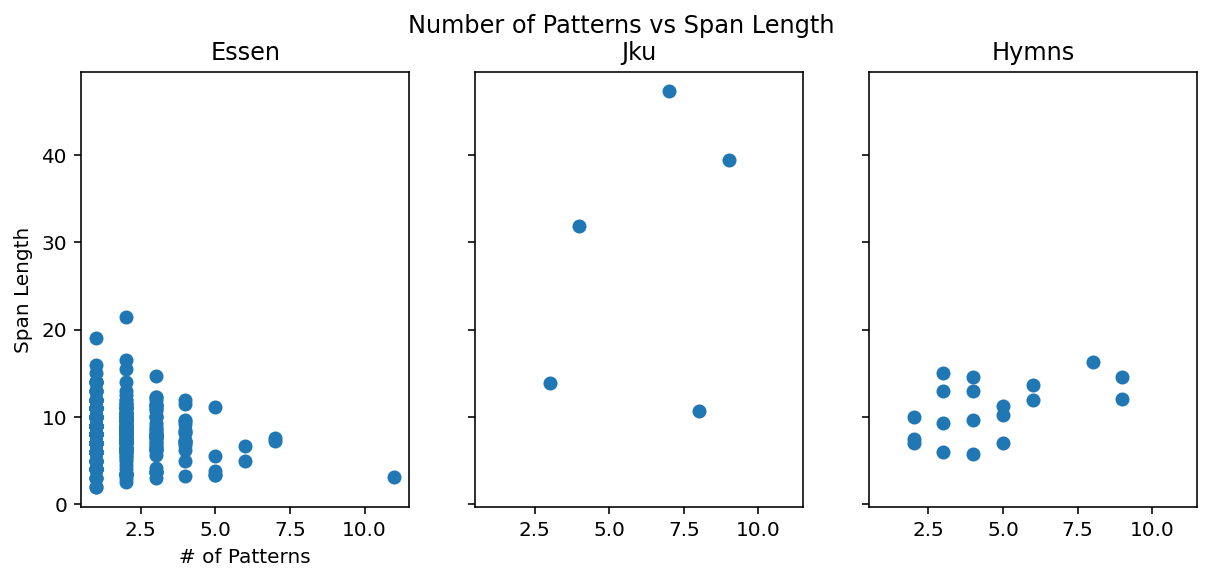

In [53]:
# Compute pattern length vs span length
from common import gzPickleIter

datasets = [
    gzPickleIter('../datasets/essen/essen300.pkl.gz'),
    gzPickleIter('../datasets/jku/jku.pkl.gz'),
    gzPickleIter('../datasets/hymns/hymns.pkl.gz')
]

allLengths = []
for d in datasets:
    lengths = []
    for x in d:
        patterns = x[1]
        avgSpanLength = np.mean([e-s for p in patterns for s, e in p])
        lengths.append((len(patterns), avgSpanLength))
    allLengths.append(lengths)

fig, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)
x, y = zip(*allLengths[0])
ax[0].scatter(x, y)
ax[0].set_title('Essen')
ax[0].set_ylabel('Span Length')
ax[0].set_xlabel('# of Patterns')
x, y = zip(*allLengths[1])
ax[1].scatter(x, y)
ax[1].set_title('Jku')
x, y = zip(*allLengths[2])
ax[2].scatter(x, y)
ax[2].set_title('Hymns')
fig.suptitle('Number of Patterns vs Span Length')

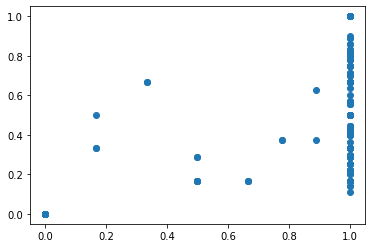

In [94]:
dataset = 'hymns'
algorithm = 'repair'
pipeline = createPipeline(['../lsresults.gz'], [
    openFiles,
    toDicts,
    filterBy(lambda d: d['algorithm'] == algorithm and d['dataset'] == dataset and d['viewpoints'] == ('duration',))
])

precs = []
recs = []
for d in pipeline:
    precs.append(d['precision'])
    recs.append(d['recall'])
fig, ax = plt.subplots()
ax.scatter(recs, precs)


/tmp/ipykernel_234/1832512130.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


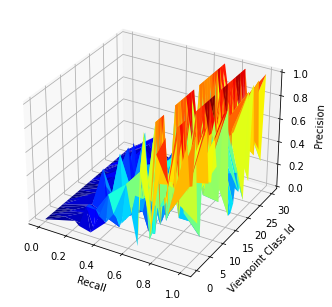

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt, cm
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(rs, vs, ps, cmap=cm.jet)
ax.set_xlabel('Recall')
ax.set_ylabel('Viewpoint Class Id')
ax.set_zlabel('Precision')
# ax.invert_xaxis()
# # ax.invert_yaxis()
# ax.zaxis.set_rotate_label(False)
# ax.azim = 110
# ax.elev = 10
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fns = [
    openFiles,
    toDicts,
    filterBy(lambda d: d['algorithm'] == 'longestFirst'),
    filterBy(lambda d: d['dataset'] == 'essen'),
    filterBy(lambda d: d['viewpoints'] == ('duration',)),
    apply(lambda d: (d['precision'], d['recall'])),
    unpack
]

precisions, recalls = createPipeline(['../results.gz'], fns)
print(len(precisions), len(recalls))
fig, ax = plt.subplots()
ax.hist(recalls)


In [ ]:
def plotPRCurve(ax, data1, data2, params={}):
    out = ax.scatter(data1, data2, **params)
    return out

def plotPRHist(ax, data, params={}):
    out = ax.hist(data, **params)
    return out

# Create B&W plot for P&R for each alg on each dataset
def plotBW(ax, data, params={}):
    out = ax.boxplot(data, **params)
    return out

In [ ]:
def getPrecisionAndRecall(filename, algorithm, dataset):
    precisions, recalls = createPipeline([filename], [
        openFiles,
        toDicts,
        filterBy(lambda d: d['algorithm'] == algorithm and d['dataset'] == dataset),
        apply(lambda d: (d['precision'], d['recall'])),
        unpack
    ])
    return precisions, recalls

In [30]:
import numpy as np
thresholds = getThresholds('../blstrictresults.gz', 'longestFirst', 'hymns')
print(thresholds.keys())
for t in sorted(thresholds):
    print(t, np.mean(thresholds[t]))

dict_keys([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.0, 0.1, 0.2, 0.3])
0.0 0.9762308998302207
0.1 0.5159969817015657
0.2 0.4862856064893416
0.3 0.44042633465383896
0.4 0.3637662705149972
0.5 0.31975570647047724
0.6 0.23487549518958686
0.7 0.16012544802867384
0.8 0.11685531031880778
0.9 0.08058856819468026
1.0 0.020118845500848897
